In [1]:
# import essential packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Dense, Input
from keras.models import Model
import scipy
from scipy.sparse import hstack
import logging

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/bza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/bza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# setting seed
np.random.seed(0)
warnings.filterwarnings('ignore')

## 1. Brief Introduction of Data Set and Data Modelling Problem

The scope of the data analysis involves examining three datasets: 'BX-Books.csv',
'BX-Users.csv', and 'BX-Ratings.csv', to gain insights into factors influencing book sales and
customer satisfaction in a bookstore.

The objective is to identify key factors influencing book sales and user satisfaction in the
online bookstore. This includes understanding the relationship between book
characteristics, user demographics, and user ratings. By analysing these factors, the aim is to
provide actionable insights to managers for making data-driven decisions on which books to
purchase and avoid

### 1.1. Importing Dataset CSVs

In [3]:
# Importing the 3 csvs ('BX-Books.csv', 'BX-Users.csv', and 'BX-Ratings.csv')

# Importing BX-Books csv
books_df = pd.read_csv("BX-Books.csv", delimiter=",") 
books_df.columns = books_df.columns.str.strip()

# Importing BX-Ratings csv
ratings_df = pd.read_csv("BX-Ratings.csv", delimiter=",")  
ratings_df.columns = ratings_df.columns.str.strip()

# Importing BX-Users csv
users_df = pd.read_csv("BX-Users.csv", delimiter=",") 
users_df.columns = users_df.columns.str.strip()


## 2. Exploratory Data Analysis

### 2.1 Examining Target Variable (Book_Ratings)

Before we perform initial investigations on data to discover patterns and spot anomalies/inconsistencies in
our data, we will first take a look at our target variable, Book_Rating in ratings_df.

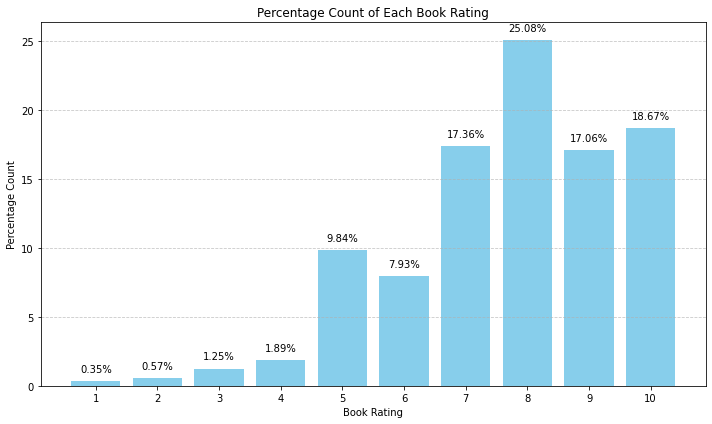

In [4]:
# Calculate the percentage count of each unique value in the 'Book_Rating' column
rating_counts = ratings_df['Book-Rating'].value_counts(normalize=True) * 100

rating_counts_df = pd.DataFrame(rating_counts)
rating_counts_df.reset_index(inplace=True)

# Rename the columns for clarity
rating_counts_df.columns = ['Book-Rating', 'Percentage Count']

# Sort the DataFrame by the 'Book-Rating' column
rating_counts_df.sort_values(by='Book-Rating', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(rating_counts_df['Book-Rating'], rating_counts_df['Percentage Count'], color='skyblue')

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.xlabel('Book Rating')
plt.ylabel('Percentage Count')
plt.title('Percentage Count of Each Book Rating')
plt.xticks(rating_counts_df['Book-Rating'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


One notable observation is that the distribution of ratings across the different categories is largely imbalanced. For instance, Book-Ratings = "1", "2", "3" together account for less than 3% of the whole dataset, while ratings "8", "9", "10" together account for over 60% of the dataset. This imbalance in something notable which can affect the performance of the machine learning models (Aguiar, 2024).

Aguiar, H. (2024). What Is Imbalanced Data and How to Handle It? TurinTech AI. Retrieved May 1, 2024, from https://www.turintech.ai/what-is-imbalanced-data-and-how-to-handle-it/

### 2.2 Data Cleaning

#### 2.2.1 Remove Trailing " 

In [5]:
# Remove trailing " from the 'User-Country' and 'User-Age' columns in the users DataFrame
users_df['User-Country'] = users_df['User-Country'].str.strip('"')
users_df['User-Age'] = users_df['User-Age'].str.strip('"')


During the inspection of the dataset, trailing " were found in the users_df in the User-Country and User-Age columns. These inconsistencies could potentially affect the data analysis, hence a data preprocessing step to remove these extraneous characters was carried out. By removing the trailing " from these columns, we ensure that the data is clean and consistent, which is essential for accurate analysis and interpretation.

#### 2.2.2 Check For Missing Data

In [6]:
# Define the total length of each DataFrame
books_total_length = len(books_df)
ratings_total_length = len(ratings_df)
users_total_length = len(users_df)

# Check number of rows with missing values (NA) in each DataFrame
books_rows_with_na = books_df.isna().any(axis=1).sum() + books_df.astype(str).apply(lambda x: x.str.contains('n/a', case=False)).any(axis=1).sum()
ratings_rows_with_na = ratings_df.isna().any(axis=1).sum()
users_rows_with_na = users_df.isna().any(axis=1).sum() + users_df.astype(str).apply(lambda x: x.str.contains('n/a', case=False)).any(axis=1).sum()

# Print the number of rows with missing values and total length of each DataFrame
print("Number of rows with missing values in Books DataFrame:", books_rows_with_na, "/", books_total_length)
print("Number of rows with missing values in Ratings DataFrame:", ratings_rows_with_na, "/", ratings_total_length)
print("Number of rows with missing values in Users DataFrame:", users_rows_with_na, "/", users_total_length)


Number of rows with missing values in Books DataFrame: 0 / 18185
Number of rows with missing values in Ratings DataFrame: 0 / 204164
Number of rows with missing values in Users DataFrame: 20430 / 48299


Checking for missing values (considering those which have empty fields as well as those which contains the string "n/a"), we can see that there are 0 missing values in books_df and ratings_df, but 20430 missing values in the users_df. 

In [7]:
# Calculate the percentage of missing values in each column of the Users DataFrame
users_missing_percentage = ((users_df.isna().sum() + users_df.astype(str).apply(lambda x: x.str.contains('n/a', case=False)).sum()) / len(users_df)) * 100

# Print the percentage of missing values in each column
print("Percentage of missing values in each column of Users DataFrame:")
print(users_missing_percentage)


Percentage of missing values in each column of Users DataFrame:
User-ID          0.000000
User-City        0.128367
User-State       1.621152
User-Country     1.393404
User-Age        39.238908
dtype: float64


Upon inspecting the users_df dataset, we can see that there are no missing values for the User-ID column. For the User-City, User-State, User-Country and User-Age columns, percentage of missing values is 0.128367%, 1.621152%, 1.393404% and 39.238908% respectively.

To handle these missing values, we first look into what type of missing data it is. From observation, the probability of the missing data is unrelated to any other variables and is unrelated to the variable with missing values itself, hence missing values are missing completely at random (MCAR). 

Firstly, we look into rows with missing values in the the User-Age field. Despite the large percentage of missing values, we choose to remove these rows because the missing values are not systematically related to any other variables in the dataset. Therefore, removing these rows is unlikely to bias our analysis, and it allows us to work with a cleaner dataset without imputing potentially unreliable data.

In [8]:
# Remove rows with missing values in the User-Age field
users_df_cleaned = users_df.dropna(subset=['User-Age'])


In [9]:
# Calculate the percentage of missing values in each column of the Users DataFrame
users_missing_percentage = ((users_df_cleaned.isna().sum() + users_df_cleaned.astype(str).apply(lambda x: x.str.contains('n/a', case=False)).sum()) / len(users_df_cleaned)) * 100

# Print the percentage of missing values in each column
print("Percentage of missing values in each column of Users DataFrame:")
print(users_missing_percentage)


Percentage of missing values in each column of Users DataFrame:
User-ID         0.000000
User-City       0.085188
User-State      1.915017
User-Country    2.283027
User-Age        0.000000
dtype: float64


Secondly, we look into the rows where User-City, User-State and User-Country is missing. Since percentage of missing values is low User-City, User-State, User-Country is relatively low with missing percentages of 0.085188%, 1.915017% and 2.283027% respectively, we decided to remove the corresponding rows. The missing values are negligible and removing them would not significantly impact the overall dataset. 

We will also be removing rows with Book-Publisher = 'Not Avail'. 

Retaining rows with incomplete location information could introduce bias or inaccuracies in subsequent analysis. Therefore, to ensure data quality and reliability, we opted to remove these rows with missing values in the columns.

In [10]:
# Remove rows with missing values or 'n/a' values in User-City, User-State, and User-Country
users_df_cleaned = users_df_cleaned.dropna(subset=['User-City', 'User-Country'])
users_df_cleaned = users_df_cleaned[~users_df_cleaned['User-State'].str.contains('n/a', case=False)]
 
# Remove rows with Book-Publisher = 'Not Avail'
books_df = books_df[books_df['Book-Publisher'] != 'Not Avail']

# Reset the index after removing rows
users_df_cleaned.reset_index(drop=True, inplace=True)

# Calculate the percentage of missing values in each column of the Users DataFrame
users_missing_percentage = ((users_df_cleaned.isna().sum() + users_df_cleaned.astype(str).apply(lambda x: x.str.contains('n/a', case=False)).sum()) / len(users_df_cleaned)) * 100

# Print the percentage of missing values in each column
print("Percentage of missing values in each column of Users DataFrame:")
print(users_missing_percentage)


Percentage of missing values in each column of Users DataFrame:
User-ID         0.0
User-City       0.0
User-State      0.0
User-Country    0.0
User-Age        0.0
dtype: float64


As seen, all fields with missing values have now been accounted for, and we will proceed on to merging the dataframes of the 3 csvs (books_df, users_df, ratings_df)

### 2.3 Merging Dataframes

In the initial preprocessing step, we merge the three respective dataframes using inner joins. First, the ratings_df is merged with the books_df based on the common ISBN column. This combined dataframe is then merged with the users_df_cleaned dataframe based on the common User-ID column. By employing an inner join, we ensure that only the records with matching ISBN and User-ID values in both dataframes are included in the resulting dataframes.

In [11]:
# Merge the dataframes on the 'ISBN' column
combined_ratings_books_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner')

merged_data = pd.merge(combined_ratings_books_df, users_df_cleaned, on='User-ID', how='inner')

print(merged_data.head())


   User-ID        ISBN  Book-Rating                          Book-Title  \
0    16877  038550120X            9                     A Painted House   
1    16877  034539657X            7            Dark Rivers of the Heart   
2    16877  0743211383            3                        Dreamcatcher   
3    16877  0786868716           10  The Five People You Meet in Heaven   
4    16877  0553225855            8             Minds of Billy Milligan   

      Book-Author  Year-Of-Publication    Book-Publisher User-City User-State  \
0    JOHN GRISHAM                 2001         Doubleday   houston   arkansas   
1  Dean R. Koontz                 1995  Ballantine Books   houston   arkansas   
2    Stephen King                 2001          Scribner   houston   arkansas   
3     Mitch Albom                 2003          Hyperion   houston   arkansas   
4    Daniel Keyes                 1982      Bantam Books   houston   arkansas   

  User-Country User-Age  
0          usa       37  
1         

Upon further inspection, we have also decided to remove the User-ID column because it is likely to not provide any valuable information for predicting book ratings. It serves as an identifier and including it as a feature would introduce noise to the model without adding any predictive power. Removing it simplifies the dataset and improves the quality of input data for the machine learning model, ultimately leading to better predictive performance.

In [12]:
# Drop User-ID column
merged_data.drop(columns=['User-ID'], inplace=True)

# Shift the the Book-Rating column to the last column for easy reference
book_rating = merged_data['Book-Rating']
merged_data.drop(columns=['Book-Rating'], inplace=True)
merged_data['Book-Rating'] = book_rating


print(merged_data.head())

         ISBN                          Book-Title     Book-Author  \
0  038550120X                     A Painted House    JOHN GRISHAM   
1  034539657X            Dark Rivers of the Heart  Dean R. Koontz   
2  0743211383                        Dreamcatcher    Stephen King   
3  0786868716  The Five People You Meet in Heaven     Mitch Albom   
4  0553225855             Minds of Billy Milligan    Daniel Keyes   

   Year-Of-Publication    Book-Publisher User-City User-State User-Country  \
0                 2001         Doubleday   houston   arkansas          usa   
1                 1995  Ballantine Books   houston   arkansas          usa   
2                 2001          Scribner   houston   arkansas          usa   
3                 2003          Hyperion   houston   arkansas          usa   
4                 1982      Bantam Books   houston   arkansas          usa   

  User-Age  Book-Rating  
0       37            9  
1       37            7  
2       37            3  
3       37  

After the initial step of data wrangling, we have the following numerical and categorical variables:

Numerical Variables - Year-Of-Publication, User-Age  
  
Categorical Variables - ISBN, Book-Title, Book-Author, Book-Publisher, User-City, User-State, User-Country

### 2.4 Checking For Outliers (For Numerical Data)

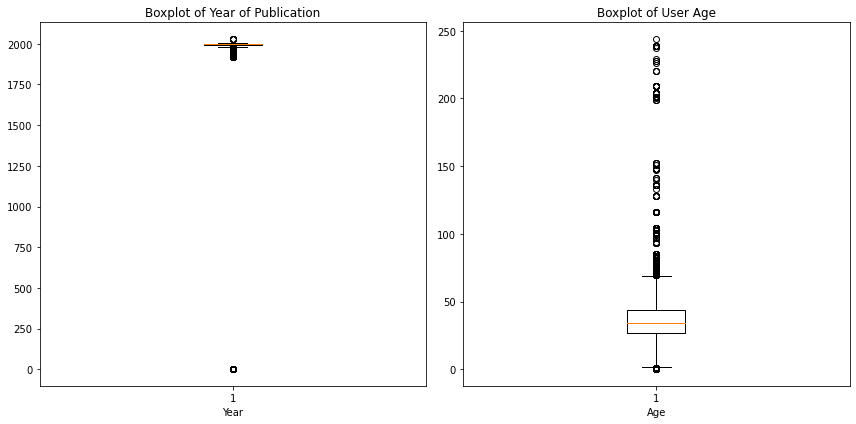

In [13]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for Year-Of-Publication
axes[0].boxplot(merged_data['Year-Of-Publication'])
axes[0].set_title('Boxplot of Year of Publication')
axes[0].set_xlabel('Year')

# Boxplot for User-Age
axes[1].boxplot(merged_data['User-Age'].astype(float))
axes[1].set_title('Boxplot of User Age')
axes[1].set_xlabel('Age')

plt.tight_layout()  
plt.show()


From the boxplot of Year of Publication, we can see that there are multiple points where the Year of Pulication is 0, which is highly unlikely and suggests erroneous or missing data, since a book is likely to not have a publication year of 0. Therefore, we have decided to remove the rows associated with these erroneous data points to ensure the integrity of our analysis.

From the boxplot of User Age, we can see that there are multiple points where User Age is above 117, which is the oldest recorded person alive. (Martinez, 2024). Therefore, we conclude that these data points are likely erroneous or represent outliers. Therefore, to ensure the reliability of our analysis, we have decided to remove all data points where the User Age exceeds 117. Also, we have decided to remove all data points for User Age <= 6 because it is found that reading readiness age starts from 6-7 years old on average (Ward, 2022).

Martinez, J. (2024, March 4). California-born woman, Maria Branyas Morera, is world's oldest person at 117. FOX40. Retrieved May 1, 2024, from https://thehill.com/changing-america/well-being/longevity/4507292-california-born-woman-is-the-oldest-person-in-the-world/

Ward, M. (2022, June 3). Best Age to Start Teaching Kids to Read: 5 Signs They're Ready. iCode School. Retrieved May 6, 2024, from https://icodeschool.com.au/best-age-to-start-teaching-kids-to-read-5-signs-theyre-ready/

In [14]:
merged_data['User-Age'] = pd.to_numeric(merged_data['User-Age'], errors='coerce')

merged_data = merged_data[merged_data['Year-Of-Publication'] != 0]

merged_data = merged_data[(merged_data['User-Age'] > 6) & (merged_data['User-Age'] <= 117)]


## 3. Data Pre-Processing

The data pre-processing section aims to transform raw data into a usable and understandable format.

### 3.1 Dropping Redundant Columns

For the first step of data-preprocessing, we will be looking at the 3 columns that provide geographical information about users - User-City, User-State, and User-Country.

We have decided to remove the User-City and User-State column, and retain only the User-Country column, because the User-Country column offers a more generalized representation of users' locations compared to User-City and User-State, which provide more specific details. By focusing on User-Country, we simplify the dataset and eliminate redundancy while still preserving essential information about users' geographical locations.


In [15]:
# Drop User-City and User-State columns
merged_data.drop(['User-City', 'User-State'], axis=1, inplace=True)


We have also decided to remove the ISBN column because while ISBNs are unique identifiers for books, the ISBN does not provide much useful information or features for the machine learning prediction target Book-Rating. By excluding the ISBN column, we reduce the dimensionality of our dataset and simplify our model, focusing on more relevant features that can better contribute to the prediction task.

In [16]:
merged_data.drop(columns=['ISBN'], inplace=True)


print(merged_data.head())

                           Book-Title     Book-Author  Year-Of-Publication  \
0                     A Painted House    JOHN GRISHAM                 2001   
1            Dark Rivers of the Heart  Dean R. Koontz                 1995   
2                        Dreamcatcher    Stephen King                 2001   
3  The Five People You Meet in Heaven     Mitch Albom                 2003   
4             Minds of Billy Milligan    Daniel Keyes                 1982   

     Book-Publisher User-Country  User-Age  Book-Rating  
0         Doubleday          usa        37            9  
1  Ballantine Books          usa        37            7  
2          Scribner          usa        37            3  
3          Hyperion          usa        37           10  
4      Bantam Books          usa        37            8  


We will also be removing the rows for User-Country containing:
1. "far away..." because it is vague and does not provide any useful geographical input to our machine learning task
2. "quit" because it is not a valid country and does not provide any useful geographical input to our machine learning task
3. "ysa" because it is not a valid country and does not provide any useful geographical input to our machine learning task
4. "universe" because it is not a valid country and does not provide any useful geographical input to our machine learning task

In [17]:
# Remove rows where 'User-Country' is 'far away...', 'quit', 'ysa', and 'universe'
merged_data = merged_data[~merged_data['User-Country'].str.strip().isin(['far away...', 'quit', 'ysa', 'universe'])]

### 3.2 Train-Test Split

Next, we will be conducting the train-test split. The train-test split is done before the text preprocessing, encoding to prevent data leakage, which could occur when the test set inadvertently influences the training process. Data leakage can happen if text preprocessing techniques or encoding methods are applied to the entire dataset because the model could be learning information from the test set that it should not have access to during the model training. If feature scaling is applied before the train-test split, information about the data distribution in the test set may also influence the scaling process, leading to biased results. Therefore by conducting the train-test split before these steps, we ensure that the model is only trained on training data and evaluated on unseen data in the test set.

In [18]:
# Separate features (X) and target variable (y)
X = merged_data.drop(columns=['Book-Rating'])
y = merged_data['Book-Rating']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

'''
print(X_train.head())
print(y_train.head())
'''

Training set shape: (95165, 6) (95165,)
Testing set shape: (40785, 6) (40785,)


'\nprint(X_train.head())\nprint(y_train.head())\n'

### 3.3 Text Preprocessing 

Next, we will process the columns with text - "Book-Title", "Book-Author", "Book-Publisher". 

We first tokenised the text using NLTK's word_tokenize function, breaking it down into individual words or tokens. The tokens are then converted to lowercase to ensure consistency in text representation. Punctuation marks are then removed to focus on the essential content of the text.

Afterwhich, we moved stopwords (eg. common words like "the," "and," "is," etc.) that don't add much meaning to the text using NLTK's English stopwords list.

Lemmatization is then performed to reduce words to their base or dictionary form, which standardizes text and helps capture word meanings more accurately.

Finally, the preprocessed tokens are joined back together to form a single string output of the cleaned and normalised text.

In [19]:
# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to the 'Book-Title' column in the training set
X_train['Book-Title'] = X_train['Book-Title'].apply(preprocess_text)

# Apply preprocessing to the 'Book-Author' column in the training set
X_train['Book-Author'] = X_train['Book-Author'].apply(preprocess_text)

# Apply preprocessing to the 'Book-Publisher' column in the training set
X_train['Book-Publisher'] = X_train['Book-Publisher'].apply(preprocess_text)

# Apply preprocessing to the 'Book-Title' column in the test set
X_test['Book-Title'] = X_test['Book-Title'].apply(preprocess_text)

# Apply preprocessing to the 'Book-Author' column in the test set
X_test['Book-Author'] = X_test['Book-Author'].apply(preprocess_text)

# Apply preprocessing to the 'Book-Publisher' column in the test set
X_test['Book-Publisher'] = X_test['Book-Publisher'].apply(preprocess_text)

# Print the updated DataFrames
print("Updated Training Set:")
print(X_train.head())
print("\nUpdated Test Set:")
print(X_test.head())


Updated Training Set:
                                Book-Title         Book-Author  \
3210                              bleacher        john grisham   
32898      le pã ãâ¨re de no pã ãâ¨res      bernard werber   
107888  chroniques de san francisco tome 1    armistead maupin   
62699                           hour novel  michael cunningham   
127935                 der dritte zwilling         ken follett   

        Year-Of-Publication Book-Publisher User-Country  User-Age  
3210                   2003      doubleday          usa        35  
32898                  2000            lgf       france        31  
107888                 2000  edition 10/18       france        18  
62699                  2002        picador          usa       103  
127935                 1999    lã ãâ¼bbe      germany        20  

Updated Test Set:
                            Book-Title     Book-Author  Year-Of-Publication  \
82354                    summer island  kristin hannah                 2002

Before we continue on with the text processing, we will be using WordCloud to inspect the textual data of the "Book-Title", "Book-Author", "Book-Publisher" columns visually to identify the common words as well as spot any inconsistencies in the data.

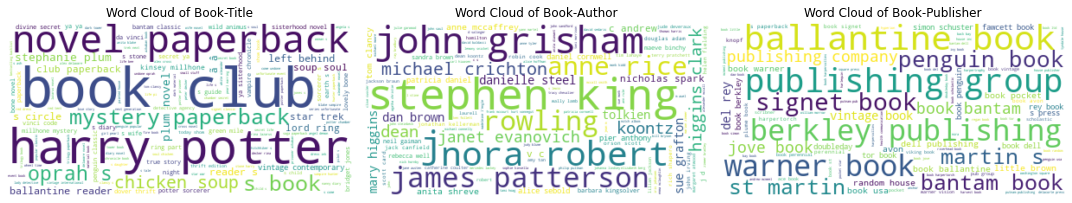

In [20]:
# Function to generate and plot word clouds for each specified column side by side
def generate_word_clouds_side_by_side(columns):
    # Create subplots
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 5))  # Adjust figsize as needed

    # Generate and plot word clouds for each specified column
    for i, column_name in enumerate(columns):
        # Concatenate all values in the specified column into a single string
        all_values = ' '.join(X_train[column_name])
        
        # Generate word cloud for the current column
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(all_values)

        # Plot the word cloud in the corresponding subplot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud of {column_name}')
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Specify columns for which to generate word clouds
columns = ['Book-Title', 'Book-Author', 'Book-Publisher']

# Generate and plot word clouds side by side for the specified columns
generate_word_clouds_side_by_side(columns)


The wordcloud gives us a good visualisation and summary of what are the words in each respective column, which we will use for further analysis.

TF-IDF vectorisation is applied here, where the textual data for “Book-Title”, “Book-Author”, “Book-Publisher” is converted into numerical vectors to be used as input features into the machine learning model. The resulting TF-IDF matrices will capture the importance of each word in contextual detail, enabling machine learning models to learn patterns and make predictions based on the contextual detail.

In [21]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer_title = TfidfVectorizer()
tfidf_vectorizer_author = TfidfVectorizer()
tfidf_vectorizer_publisher = TfidfVectorizer()

# Fit and transform each text column separately
X_train_tfidf_title = tfidf_vectorizer_title.fit_transform(X_train['Book-Title'])
X_train_tfidf_author = tfidf_vectorizer_author.fit_transform(X_train['Book-Author'])
X_train_tfidf_publisher = tfidf_vectorizer_publisher.fit_transform(X_train['Book-Publisher'])

'''
print("TF-IDF matrix for Book-Title:")
print(X_train_tfidf_title)

print("TF-IDF matrix for Book-Author:")
print(X_train_tfidf_author)

print("TF-IDF matrix for Book-Publisher:")
print(X_train_tfidf_publisher)
'''

# Fit and transform each text column separately
X_test_tfidf_title = tfidf_vectorizer_title.transform(X_test['Book-Title'])
X_test_tfidf_author = tfidf_vectorizer_author.transform(X_test['Book-Author'])
X_test_tfidf_publisher = tfidf_vectorizer_publisher.transform(X_test['Book-Publisher'])

'''
print("TF-IDF matrix for Book-Title:")
print(X_test_tfidf_title)

print("TF-IDF matrix for Book-Author:")
print(X_test_tfidf_author)

print("TF-IDF matrix for Book-Publisher:")
print(X_test_tfidf_publisher)
'''

'\nprint("TF-IDF matrix for Book-Title:")\nprint(X_test_tfidf_title)\n\nprint("TF-IDF matrix for Book-Author:")\nprint(X_test_tfidf_author)\n\nprint("TF-IDF matrix for Book-Publisher:")\nprint(X_test_tfidf_publisher)\n'

### 3.4 Encoding Categorial Variables

Before we look into encoding the remaining categorical variables, we will first check the number of unique values for each categorical variable to understand the best way to encode these categorical variables for input to machine learning models. Since "Book-Title", "Book-Author", "Book-Publisher" has already been converted into a TF-IDF Matrix, we will focus on encoding the remaining categorical variable - "User-Country".

In [22]:
# Print the number of unique values for each categorical variable
print("Number of unique countries:", len(X_train['User-Country'].unique()))

X_train.head()


Number of unique countries: 99


,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,User-Country,User-Age
3210,bleacher,john grisham,2003,doubleday,usa,35
32898,le pã ãâ¨re de no pã ãâ¨res,bernard werber,2000,lgf,france,31
107888,chroniques de san francisco tome 1,armistead maupin,2000,edition 10/18,france,18
62699,hour novel,michael cunningham,2002,picador,usa,103
127935,der dritte zwilling,ken follett,1999,lã ãâ¼bbe,germany,20


#### 3.4.1 Aggregation and One Hot Encoding For Categorical Variable ("User-Country")

For the "User-Country" column, we will use one-hot encoding. One-hot encoding creates new dummy binary variables for every class in each categorical feature for categorical variables with no ordinal relationship. This method is suitable for categorical variables with a small number of unique categories without an ordinal relationship. Before we proceed with one hot encoding, we will first aggregate "User-Country" column into the different continents instead as the current number of unique categories for the column "User-Country" is still quite high (count: 99).

In [23]:
# Mapping dictionary for continents
country_to_continent = {
    'usa': 'North America',
    'portugal': 'Europe',
    'netherlands': 'Europe',
    'canada': 'North America',
    'malaysia': 'Asia',
    'spain': 'Europe',
    'philippines': 'Asia',
    'germany': 'Europe',
    'australia': 'Australia',
    'united kingdom': 'Europe',
    'italy': 'Europe',
    'romania': 'Europe',
    'iran': 'Asia',
    'austria': 'Europe',
    'dominican republic': 'North America',
    'south korea': 'Asia',
    'france': 'Europe',
    'india': 'Asia',
    'switzerland': 'Europe',
    'finland': 'Europe',
    'greece': 'Europe',
    'phillipines': 'Asia',
    'japan': 'Asia',
    'belgium': 'Europe',
    'tajikistan': 'Asia',
    'united state': 'North America',
    'brazil': 'South America',
    'hong kong': 'Asia',
    'cayman islands': 'North America',
    'new zealand': 'Australia',
    'china': 'Asia',
    'kuwait': 'Asia',
    'luxembourg': 'Europe',
    'turkey': 'Asia',
    'norway': 'Europe',
    'peru': 'South America',
    'ireland': 'Europe',
    'czech republic': 'Europe',
    'sweden': 'Europe',
    'trinidad and tobago': 'North America',
    'tunisia': 'Africa',
    'singapore': 'Asia',
    'denmark': 'Europe',
    'thailand': 'Asia',
    'indonesia': 'Asia',
    'mexico': 'North America',
    'south africa': 'Africa',
    'macedonia': 'Europe',
    'mauritius': 'Africa',
    'poland': 'Europe',
    'yugoslavia': 'Europe',
    'iceland': 'Europe',
    'costa rica': 'North America',
    'qatar': 'Asia',
    'bahamas': 'North America',
    'united states': 'North America',
    'tanzania': 'Africa',
    'u.k.': 'Europe',
    'egypt': 'Africa',
    'honduras': 'North America',
    'ecuador': 'South America',
    'bahrain': 'Asia',
    'pakistan': 'Asia',
    'algeria': 'Africa',
    'argentina': 'South America',
    'england': 'Europe',
    'chile': 'South America',
    'pender': 'North America',
    'belize': 'North America',
    'israel': 'Asia',
    'mozambique': 'Africa',
    'venezuela': 'South America',
    'bulgaria': 'Europe',
    'taiwan': 'Asia',
    'euskal herria': 'Europe',
    'deutschland': 'Europe',
    'puerto rico': 'North America',
    'nigeria': 'Africa',
    'slovenia': 'Europe',
    'angola': 'Africa',
    'catalonia': 'Europe',
    'zambia': 'Africa',
    'uruguay': 'South America',
    'urugua': 'South America',
    'paraguay': 'South America',
    'slovakia': 'Europe',
    'oman': 'Asia',
    'america': 'North America',
    'papua new guinea': 'Australia',
    'madagascar': 'Africa',
    'bermuda': 'North America',
    'saudi arabia': 'Asia',
    'antigua and barbuda': 'North America',
    'afghanistan': 'Asia',
    'croatia': 'Europe',
    'u.s.a.': 'North America',
    'grenada': 'North America',
    'orense': 'Europe',
    'panama': 'North America',
    'catalunya': 'Europe',
    'moldova': 'Europe',
    'vietnam': 'Asia',
    'barbados': 'North America',
    'russia': 'Europe',
    'hungary': 'Europe',
    'wales': 'Europe',
    'españa': 'Europe',
    'jersey': 'Europe',
    'morocco': 'Africa',
    'la france': 'Europe',
    'kenya': 'Africa',
    'aruba': 'North America'
}

# Map countries to continents
X_train['User-Country'] = X_train['User-Country'].str.strip().map(country_to_continent)
X_test['User-Country'] = X_test['User-Country'].str.strip().map(country_to_continent)

# Display the updated DataFrame
print(X_train.head())
print(X_train.shape)

print("Number of unique countries:", len(X_train['User-Country'].unique()))

                                Book-Title         Book-Author  \
3210                              bleacher        john grisham   
32898      le pã ãâ¨re de no pã ãâ¨res      bernard werber   
107888  chroniques de san francisco tome 1    armistead maupin   
62699                           hour novel  michael cunningham   
127935                 der dritte zwilling         ken follett   

        Year-Of-Publication Book-Publisher   User-Country  User-Age  
3210                   2003      doubleday  North America        35  
32898                  2000            lgf         Europe        31  
107888                 2000  edition 10/18         Europe        18  
62699                  2002        picador  North America       103  
127935                 1999    lã ãâ¼bbe         Europe        20  
(95165, 6)
Number of unique countries: 6


For better representation of the column "User-Country", we will rename it to "User-Continent" as we have aggregated and reclassified the countries into the respective continents

In [24]:
# Rename the 'User-Country' column to 'User-Continent'
X_train.rename(columns={'User-Country': 'User-Continent'}, inplace=True)
X_test.rename(columns={'User-Country': 'User-Continent'}, inplace=True)

We will now perform one-hot encoding, allowing the machine learning models to consider the effect of each continent separately without assuming any ordinal relationship between the continents.

In [25]:
# One-hot encode 'User-Continent' column in both X_train and X_test
X_train = pd.get_dummies(X_train, columns=['User-Continent'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['User-Continent'], drop_first=True, dtype=int)


### 3.5 Feature Scaling (Numerical Data)

Feature scaling will be applied to numerical data because the features are commonly not on the same scale. Machine learning models, on the other hand, are largely euclidean distance-based. Therefore, to prevent the issue where features with large units dominate over features with smaller units during the distance calculation (causing features with smallers units to be neglected), we will be appling Min-Max scaling to scale the numerical features (Toprak, 2019).

In this project, we will be using be using MinMaxScaler() to scale and preprocess the data through Min-Max Scaling method to scale the numerical data values to a range of 0-1.

Toprak, M. (2019, December 3). Why ,When to Apply Feature Scaling(Normalization) and How to Apply it with SciKit Learn. Medium. Retrieved May 1, 2024, from https://medium.com/@toprak.mhmt/why-when-to-apply-feature-scaling-normalization-and-how-to-apply-it-with-scikit-learn-fa659aa5fca8#id_token=eyJhbGciOiJSUzI1NiIsImtpZ

In [26]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Define the columns to be scaled
columns_to_scale = ['Year-Of-Publication', 'User-Age']

# Apply Min-Max Scaling to the selected columns
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#for later analysis
X_train_chart = X_train.copy()
# Print the scaled DataFrame
print(X_train.head())

                                Book-Title         Book-Author  \
3210                              bleacher        john grisham   
32898      le pã ãâ¨re de no pã ãâ¨res      bernard werber   
107888  chroniques de san francisco tome 1    armistead maupin   
62699                           hour novel  michael cunningham   
127935                 der dritte zwilling         ken follett   

        Year-Of-Publication Book-Publisher  User-Age  User-Continent_Asia  \
3210               0.754545      doubleday  0.256881                    0   
32898              0.727273            lgf  0.220183                    0   
107888             0.727273  edition 10/18  0.100917                    0   
62699              0.745455        picador  0.880734                    0   
127935             0.718182    lã ãâ¼bbe  0.119266                    0   

        User-Continent_Australia  User-Continent_Europe  \
3210                           0                      0   
32898                 

### 3.6 Combining TF-IDF Matrices with the Dataframes

In [27]:
# Drop the text columns from X_train
X_train_filtered = X_train.drop(columns=['Book-Title', 'Book-Author', 'Book-Publisher'])

# Combine the TF-IDF matrices with the remaining features in X_train
X_train = hstack((X_train_tfidf_title, X_train_tfidf_author, X_train_tfidf_publisher, X_train_filtered))

# Convert X_train to a DataFrame
X_train = pd.DataFrame(X_train.toarray())
print(X_train.head())


# Drop the text columns from X_test
X_test_filtered = X_test.drop(columns=['Book-Title', 'Book-Author', 'Book-Publisher'])

# Combine the TF-IDF matrices with the remaining features in X_test
X_test = hstack((X_test_tfidf_title, X_test_tfidf_author, X_test_tfidf_publisher, X_test_filtered))

# Convert X_test to a DataFrame
X_test = pd.DataFrame(X_test.toarray())


   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

      18377  18378  18379     18380     18381  18382  18383  18384  18385  \
0  0.000000    0.0    0.0  0.754545  0.256881    0.0    0.0    0.0    1.0   
1  0.000000    0.0    0.0  0.727273  0.220183    0.0    0.0    1.0    0.0   
2  0.000000    0.0    0.0  0.727273  0.100917    0.0    0.0    1.0    0.0   
3  0.000000    0.0    0.0  0.745455  0.880734    0.0    0.0    0.0    1.0   
4  0.707107    0.0    0.0  0.718182  0.119266    0.0    0.0    1.0    0.0   

   18386  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4

## 4. Model Selection

We will now run 2 machine learning models to test and evaluate which one performs the best. Selecting the best-performing model is crucial because ensure that the predictive model will generalise well to unseen data, and hence make accurate predictions in real-world scenarios.

The models we will be using are:
1) K-nearest-neighbours
2) Random Forest

After which, we will be evaluating each respective model with the test set.


### 4.1 K-Nearest-Neighbours

K-nearest neighbours is a non-parametric machine learning algorithm that classifies new data points based on the majority class of its K nearest neighbours within the feature space. 

Our group chose K-nearest neighbours because of its interpretability and performance. Unlike more complex models like neural networks, k-nearest neighbours can be easily understood and intrepeted. This interpretability is crucial for our project, as it allows us to gain insights into which features contribute most to the predictions. The K-nearest neighbours algorithm also it memorises the training dataset instead of learning explicit models, making it computationally efficient during training. It also tends to perform well when the dataset is not too large. Moreover, K nearest neighbours is robust to noisy data and outliers, making it suitable for real-world application (Subramanian, 2019).

Subramanian, D. (2019). A Simple Introduction to K-Nearest Neighbors Algorithm. Towards Data Science. Retrieved May 1, 2024, from https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e

In [28]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Calculate dynamic batch size
max_batch_size = 1000
num_batches = len(X_train) // max_batch_size
remainder = len(X_train) % max_batch_size
batch_sizes = [max_batch_size] * num_batches
if remainder > 0:
    batch_sizes.append(remainder)

# Initialize K-nearest-neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model in batches
for i, batch_size in enumerate(batch_sizes):
    start_index = sum(batch_sizes[:i])
    end_index = start_index + batch_size
    
    # Get batch data
    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]
    
    # Train the model on the batch
    knn_model.fit(X_batch, y_batch)
    
    # Log batch training completion
    logging.info(f"Batch {i+1}/{len(batch_sizes)} trained. Batch size: {batch_size}")

# Predict on the test set using the model
knn_predictions = knn_model.predict(X_test)

# Calculate mean squared error
mse_knn = mean_squared_error(y_test, knn_predictions)

# Calculate mean absolute error
mae_knn = mean_absolute_error(y_test, knn_predictions)

# Calculate R-squared
r2_knn = r2_score(y_test, knn_predictions)

# Calculate adjusted R-squared
n = len(y_test)
p = X_test.shape[1]
adj_r2_knn = 1 - (1 - r2_knn) * (n - 1) / (n - p - 1)

# Calculate root mean square error
rmse_knn = np.sqrt(mse_knn)

print("K-nearest-neighbors Regression Metrics:")
print("Adjusted R-squared:", adj_r2_knn)
print("Root Mean Squared Error:", rmse_knn)
print("Mean Absolute Error:", mae_knn)


2024-05-08 20:16:30,568 - INFO - Batch 1/96 trained. Batch size: 1000
2024-05-08 20:16:30,670 - INFO - Batch 2/96 trained. Batch size: 1000
2024-05-08 20:16:30,784 - INFO - Batch 3/96 trained. Batch size: 1000
2024-05-08 20:16:30,885 - INFO - Batch 4/96 trained. Batch size: 1000
2024-05-08 20:16:30,980 - INFO - Batch 5/96 trained. Batch size: 1000
2024-05-08 20:16:31,088 - INFO - Batch 6/96 trained. Batch size: 1000
2024-05-08 20:16:31,188 - INFO - Batch 7/96 trained. Batch size: 1000
2024-05-08 20:16:31,292 - INFO - Batch 8/96 trained. Batch size: 1000
2024-05-08 20:16:31,395 - INFO - Batch 9/96 trained. Batch size: 1000
2024-05-08 20:16:31,498 - INFO - Batch 10/96 trained. Batch size: 1000
2024-05-08 20:16:31,597 - INFO - Batch 11/96 trained. Batch size: 1000
2024-05-08 20:16:31,701 - INFO - Batch 12/96 trained. Batch size: 1000
2024-05-08 20:16:31,802 - INFO - Batch 13/96 trained. Batch size: 1000
2024-05-08 20:16:31,900 - INFO - Batch 14/96 trained. Batch size: 1000
2024-05-08 20:1

K-nearest-neighbors Regression Metrics:
Adjusted R-squared: -1.2138716880612925
Root Mean Squared Error: 1.9533321994422652
Mean Absolute Error: 1.5750888807159495


### 4.2 Random Forest

Random Forest is a machine learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes (classification) or the average prediction (regression) of the individual trees. The output of each respective decision tree will then be combined to give the final prediction of the target variable.

Our group chose random forest because of its interpretability and performance. Random forest allows for model interpretability through feature importance, as compared to more complex models such as neural networks which are not interpretable. Model interpretability is key for us in this project because we need to understand which features are driving the predictions. Random forest also tends to perform well over a large range of datasets, and can handle outliers and noisy data well, making it highly suited for real world applications (Sruthi, 2024).

Sruthi, E. R. (2024). Building a Random Forest Model: A Step-by-Step Guide. Analytics Vidhya. Retrieved May 1, 2024, from https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

In [29]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

rf_model_original = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model in batches
for i, batch_size in enumerate(batch_sizes):
    start_index = sum(batch_sizes[:i])
    end_index = start_index + batch_size
    
    # Get batch data
    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]
    
    # Train the model on the batch
    rf_model_original.fit(X_batch, y_batch)
    
    # Log batch training completion
    logging.info(f"Batch {i+1}/{len(batch_sizes)} trained. Batch size: {batch_size}")

# Predict on the test set
rf_predictions_original = rf_model_original.predict(X_test)

# Calculate mean squared error
mse_rf_org = mean_squared_error(y_test, rf_predictions_original)

# Calculate mean absolute error
mae_rf_org = mean_absolute_error(y_test, rf_predictions_original)

# Calculate R-squared
r2_rf_org = r2_score(y_test, rf_predictions_original)

# Calculate adjusted R-squared
n_org = len(y_test)
p_org = X_test.shape[1]
adj_r2_rf_org = 1 - (1 - r2_rf_org) * (n_org - 1) / (n_org - p_org - 1)

# Calculate root mean square error
rmse_rf_org = np.sqrt(mse_rf_org)

print("Random Forest Regression Metrics (Original Trainset):")
print("Adjusted R-squared:", adj_r2_rf_org)
print("Root Mean Squared Error:", rmse_rf_org)
print("Mean Absolute Error:", mae_rf_org)


2024-05-08 20:17:30,212 - INFO - Batch 1/96 trained. Batch size: 1000
2024-05-08 20:18:16,716 - INFO - Batch 2/96 trained. Batch size: 1000
2024-05-08 20:19:05,271 - INFO - Batch 3/96 trained. Batch size: 1000
2024-05-08 20:19:37,586 - INFO - Batch 4/96 trained. Batch size: 1000
2024-05-08 20:20:18,613 - INFO - Batch 5/96 trained. Batch size: 1000
2024-05-08 20:20:57,953 - INFO - Batch 6/96 trained. Batch size: 1000
2024-05-08 20:21:52,507 - INFO - Batch 7/96 trained. Batch size: 1000
2024-05-08 20:22:35,571 - INFO - Batch 8/96 trained. Batch size: 1000
2024-05-08 20:23:14,393 - INFO - Batch 9/96 trained. Batch size: 1000
2024-05-08 20:23:55,702 - INFO - Batch 10/96 trained. Batch size: 1000
2024-05-08 20:24:39,835 - INFO - Batch 11/96 trained. Batch size: 1000
2024-05-08 20:25:22,929 - INFO - Batch 12/96 trained. Batch size: 1000
2024-05-08 20:26:06,428 - INFO - Batch 13/96 trained. Batch size: 1000
2024-05-08 20:26:46,512 - INFO - Batch 14/96 trained. Batch size: 1000
2024-05-08 20:2

Random Forest Regression Metrics (Original Trainset):
Adjusted R-squared: -1.0398809844587555
Root Mean Squared Error: 1.8750044413334674
Mean Absolute Error: 1.470570307711168


## 5. Model Evaluation and Visualisation

In [30]:
# Define model names and preprocessing techniques
model_names = ["K-nearest-neighbors", "Random Forest"]

# Define the results as lists of lists
results = [
    [model_names[0] + " ", adj_r2_knn, rmse_knn, mae_knn],
    [model_names[1] + " ", adj_r2_rf_org, rmse_rf_org, mae_rf_org],
]

# Define the headers
headers = ["Model", "Adjusted R-squared", "Root Mean Squared Error", "Mean Absolute Error"]

# Print the table
print(tabulate(results, headers=headers))


Model                  Adjusted R-squared    Root Mean Squared Error    Mean Absolute Error
-------------------  --------------------  -------------------------  ---------------------
K-nearest-neighbors              -1.21387                    1.95333                1.57509
Random Forest                    -1.03988                    1.875                  1.47057


### 5.1 Evaluation Metrics

#### 5.1.1 Adjusted R-squared
The Adjusted R-squared metric measures the proportion of the variance explained by the machine learning model, while taking into account the number of predictor features, and can range from negative infinity to 1. This is done by penalising the addition of predictors which are unnecessary and do not improve the machine learning model performance. In this project, adjusted R-Squared hence explains the variability of the target variable book_rating, adjusted for the number of predictor features in the model. An Adjusted R-squared value close to 1 indicates a good fit of the regression model to the data.

For instance, an Adjusted R-squared of 0.80 suggests that 80% of the variability in book_rating is explained by the independent variables in the model, adjusted for the number of predictors.

#### 5.1.2 Root Mean Squared Error (RMSE)
Mean Squared Error (MSE) is the mean of the squared differences between the actual target values and predicted target values, and can range from 0 to infinity. Root Mean Square Error (RMSE) is the square root of the Mean Square Error, and in this project is used to quantify the magnitude of the mean squared deviation of the predicted book_rating and actual book_rating values. RMSE is also particularly useful as it will be in the same unit as the target variable book_rating, making it easier to interpret. Lower RMSE will suggest that the machine learning model's predictions are close to the actual values, suggesting that the regression model is a good fit to the data and is a godd estimation for book_rating.

For instance, an RMSE of 0.23 suggests that on average, the deviation of predicted book_rating from actual book_rating is 0.23.

#### 5.1.3 Mean Absolute Error
Mean Absolute Error (MAE) is the mean of the absolute difference between the actual values of book_rating and the predicted values of book_rating, and can range from 0 to infinity. In this project, MAE hence measures the average absolute deviation of predicted book rating from the actual book rating values. MAE provides a robust measure of the machine learning model's performance, as it is less sensitive to outliers compared to RMSE. A lower MAE value will suggest that the model's predictions have smaller errors, providing a more accurate estimate of the target variable book_rating.

For instance, an MAE of 0.23 suggests that on average, the absolute deviation of predicted book_rating from actual book_rating is 0.23.

As a whole, using our selected evaluation metrics of adjusted R-squared, MSE, MAE we can conclude that the Random Forest algorithm is the best performing model, which we will be using for further analysis below.


### 5.2 Feature Importance Analysis

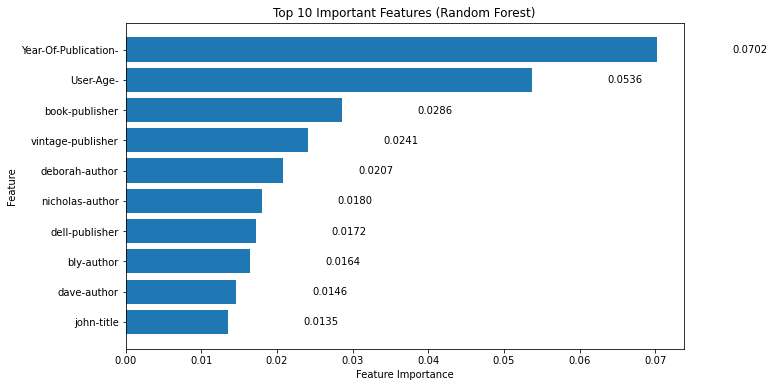

In [31]:
import matplotlib.pyplot as plt
import re

# Get feature importances
feature_importances = rf_model_original.feature_importances_
# Get feature names from TF-IDF vectorizers
feature_names_title = tfidf_vectorizer_title.get_feature_names_out()
feature_names_author = tfidf_vectorizer_author.get_feature_names_out()
feature_names_publisher = tfidf_vectorizer_publisher.get_feature_names_out()

# Combine feature names
all_feature_names = (
    feature_names_title.tolist() + 
    feature_names_author.tolist() + 
    feature_names_publisher.tolist()+
    X_train_filtered.columns.tolist()
)

title_len = len(feature_names_title.tolist())
author_len = len(feature_names_author.tolist())
publisher_len = len(feature_names_publisher.tolist())

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
# Ensure indices are within the range of the feature names list
top_indices = sorted_indices[:10]
top_feature_importances = [feature_importances[i] for i in top_indices]
top_feature_names = []
# Iterate over indices and handle potential out-of-range errors
for i in top_indices:
    if i < len(all_feature_names):
        feature_name = all_feature_names[i]
        label =''
        if i >= title_len+author_len+publisher_len:
            label = ''
        elif i <= title_len+author_len and i > title_len:
            label = 'author'
        elif i <= title_len:
            label = 'title'
        else:
            label = 'publisher'
        top_feature_names.append(feature_name+'-'+label)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_importances)), top_feature_importances, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top

for i, v in enumerate(top_feature_importances):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')  # Adjust the position for the label


plt.show()




#### 5.2.1 Feature Importance Insights for Bookstore Managers

Considering the top 3 most important features: Year-Of-Publication, User-Age, book-publisher:

##### Year-Of-Publication
In this particular case, the feature importance analysis has revealed that the "year of publication" attribute holds the highest importance score, with a value of 0.072.

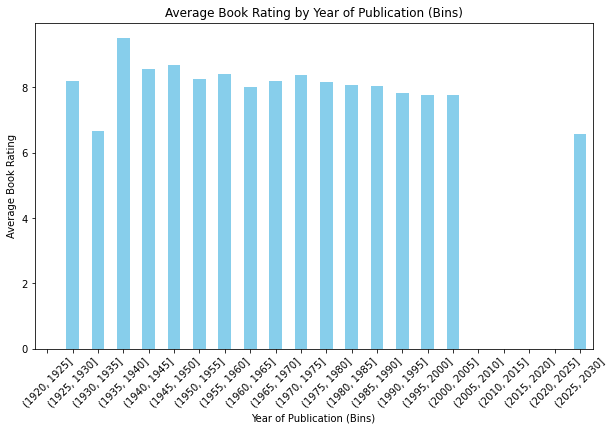

In [32]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Define the bins for years
bins = range(merged_data['Year-Of-Publication'].min(), merged_data['Year-Of-Publication'].max() + 1, 5)

# Group the data by year bins and calculate the average rating for each bin
avg_ratings = merged_data.groupby(pd.cut(merged_data['Year-Of-Publication'], bins))['Book-Rating'].mean()

# Plot the bar chart
avg_ratings.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Year of Publication (Bins)')
plt.ylabel('Average Book Rating')
plt.title('Average Book Rating by Year of Publication (Bins)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()



An analysis of book ratings grouped by publication year (5-year bins) revealed a trend in reader preference. Books published between 1930 and 1935 boasted the highest average rating, exceeding 9, while those from 1925 to 1930 fell short at just above 6. This suggests a potential shift in reader tastes during this period. Capitalizing on this data, publishers can analyze content from the high-rated era to identify popular themes, genres, and writing styles to inform future acquisitions and development.  Similarly, revisiting publishing approaches from the low-rated period may expose areas for improvement in editing, cover design, or marketing efforts. By promoting hidden gems and fostering collaboration with successful authors, publishers can curate a collection that resonates with readers, ultimately driving engagement in the literary market.

##### User-Age
User-Age also holds significant importance in predicting book ratings, with a feature importance score of 0.0536. 

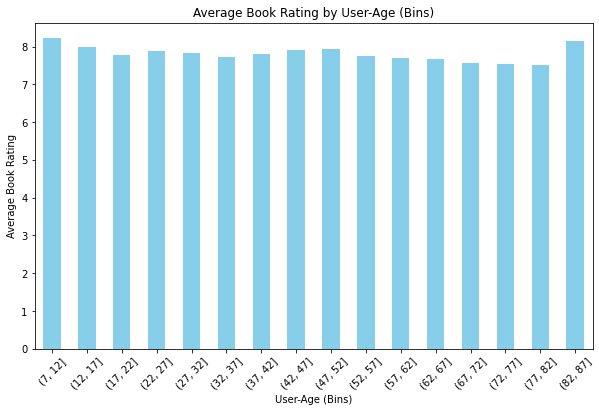

In [33]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Define the bins for years
bins = range(7, 88, 5)  # Exclude ages below 7 and above 87

# Filter the data to exclude ages above 87 and below 7
filtered_data = merged_data[(merged_data['User-Age'] >= 7) & (merged_data['User-Age'] <= 87)]

# Group the filtered data by year bins and calculate the average rating for each bin
avg_ratings = filtered_data.groupby(pd.cut(filtered_data['User-Age'], bins))['Book-Rating'].mean()

# Plot the bar chart
avg_ratings.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('User-Age (Bins)')
plt.ylabel('Average Book Rating')
plt.title('Average Book Rating by User-Age (Bins)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


The analysis of the average book ratings against user age reveals insightful trends for book managers. Notably, individuals aged 82-87 consistently provide the highest book ratings, indicating a strong satisfaction with the available literature. Conversely, the age group spanning 32-37 years appears to be the most critical, although the difference in average ratings compared to other age groups is not significant. Despite this, it may be beneficial for book managers to pay closer attention to the preferences and feedback of readers within this age bracket. Engaging with this demographic through targeted marketing campaigns, personalized recommendations, or curated book selections could help enhance their overall satisfaction and foster a deeper connection with the literary offerings.

##### book-publisher
book-publisher also holds significant importance in predicting book ratings above other features, with a feature importance score of 0.0286.

In [34]:
# Filter rows where 'Book-Publisher' contains 'book'
filtered_data = merged_data[merged_data['Book-Publisher'].str.contains('book', case=False)]

# Calculate the average book rating
average_rating = filtered_data['Book-Rating'].mean()

print("Average book rating for rows with 'Book-Publisher' containing 'book':", average_rating)


Average book rating for rows with 'Book-Publisher' containing 'book': 7.802490167623614


The analysis reveals that among the entries where the 'Book-Publisher' field contains the term 'book', the average book rating stands at approximately 7.80. This suggests a generally positive reception for books associated with publishers containing 'book' in their name. Notably, while exploring these publishers, it's essential to identify specific factors contributing to their success. This could involve examining the genres, themes, or authors prevalent in their publications, as well as any distinctive marketing or distribution strategies they employ. By delving deeper into these aspects, book managers can gain valuable insights into what resonates most with readers and leverage this knowledge to optimize their own publishing endeavors. Additionally, fostering collaboration or partnerships with successful publishers in this category may present opportunities for mutual growth and knowledge sharing. Ultimately, by leveraging these insights and relationships, publishers can strive to enhance their offerings and strengthen their position in the market, ultimately leading to increased reader satisfaction and engagement.

## 6. Areas For Improvement

### 6.1 Hyperparameter Tuning

One way to improve is to conduct hyperparameter tuning for the machine learning models, such as the number of trees in Random Forest or the number of neighbors in K-nearest-neighbors. Hyperparameter tuning allows us to optimize the model's performance metrics like accuracy, precision, recall, and F1-score. This optimization ensures that our models are better suited to capture the underlying patterns in the data, leading to improved predictive accuracy (Jain, 2023).

Jain, S. (2023, December 7). Hyperparameter tuning. GeeksforGeeks. Retrieved May 1, 2024, from https://www.geeksforgeeks.org/hyperparameter-tuning/


### 6.2 Checking For Over/Underfitting

Another way to improve is to check for Over/Underfitting through learning curves. It is important to assess if the machine learning models are overfitting (learning noise in the training data) or underfitting (too simplistic to capture patterns), and can be done by plotting learning curves which depict the model's performance (eg. accuracy/error) as a function of the training set size. Overfitting tends to show a large gap between the training and validation curves, while underfitting typically results in low performance on both sets (Bnomial, n.d.).

Bnomial. (n.d.). Overfitting and Underfitting with Learning Curves | Bnomial. Machine learning articles - Bnomial. Retrieved May 1, 2024, from https://articles.bnomial.com/overfitting-underfitting-learning-curves


## 7. Limitations

### 7.1 Limited Set Of Features

The dataset provided has a limited set of features that captures the complexities of the book_rating, hence book sales. While features like User-Age, Title-Mean-Rating, and Author-Mean-Rating provide insights, they may not fully encompass all factors influencing book rating and sales. For example, variables such as marketing efforts, book genre, seasonal trends and socioeconomic factors could also play a role in book_rating but are not included in the dataset. The absence of these variables may limit the predictive power of the machine learning models and hence the comprehensiveness of the analysis.

### 7.2 Computational Constrains For Text Processing
The second limitation would be computational constraints which lead us to be unable to deploy high-computation resource models for text processing. As the textual data columns “'Book-Title', 'Book-Author', and 'Book-Publisher' are very expansive, there are some challenges in effectively capturing the semantic, intricate relationships between the texts. Advanced models such as BERT, GPT which are built on transformer-based architectures, or deep semantic similarity models such as Siamese networks will offer much superior capabilities in understanding the nuances in our text semantics (uncovering subtle contextual cues, synonyms and underlying meanings). However, due to resource limitations we were constrained to employ simpler techniques like TF-IDF, which may not fully capture the semantic relationships within the data, hence potentially impacting the accuracy and depth of our analysis. To mitigate this, we can focus on securing additional computation resources or cloud-based solutions in future to harness more sophisticated models so as to be able to extract more meaningful insights from our textual data.